# BERT

## Import data

In [41]:
!! pip install --upgrade transformers
!! pip install tf-keras
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [42]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, create_optimizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [44]:
df = pd.read_csv("Features_For_Traditional_ML_Techniques.csv", index_col=0)

In [45]:
len(df)

134198

In [46]:
def prepare_dataset(texts, labels, tokenizer, shuffle, batch_size=32, max_length=128):
    # Convert texts to list if it's numpy array
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
        
    # Ensure labels are the right shape
    labels = np.array(labels)
    if len(labels.shape) == 1:
        labels = labels.reshape(-1, 1)
    
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        return_tensors='tf',
        max_length=max_length
    )
    
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
        },
        labels
    ))
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=50000)
    return dataset

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    df['tweet'].values,
    df['majority_target'].astype(int),
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size = 0.2,
    random_state=42
)

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [48]:
sum(y_train)/len(y_train)

0.5142398062548029

In [49]:
sum(y_val)/len(y_val)

0.5140648286140089

In [50]:
sum(y_test)/len(y_test)

0.5134500745156483

In [51]:
# Initialize model
model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=1
)

# Corrected optimizer variable
optimizer = Adam(learning_rate=9e-6)

# Compile model
model.compile(
    optimizer= optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train model

In [52]:
# Prepare datasets with optimized parameters
train_dataset = prepare_dataset(
    X_train, 
    y_train, 
    tokenizer, 
    True
)
val_dataset = prepare_dataset(
    X_val, 
    y_val, 
    tokenizer,
    False
)
test_dataset = prepare_dataset(
    X_test, 
    y_test, 
    tokenizer,
    False
)

In [53]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)

# Train model
history = model.fit(
    train_dataset,
    epochs=8,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
) 

Epoch 1/8
2684/2684 [==============================] - 2101s 765ms/step - loss: 0.6066 - accuracy: 0.7823 - val_loss: 0.3913 - val_accuracy: 0.8451 - lr: 9.0000e-06
Epoch 2/8
2684/2684 [==============================] - 2045s 762ms/step - loss: 0.3771 - accuracy: 0.8981 - val_loss: 0.2535 - val_accuracy: 0.9250 - lr: 9.0000e-06
Epoch 3/8
2684/2684 [==============================] - 2044s 761ms/step - loss: 0.3297 - accuracy: 0.9173 - val_loss: 0.3438 - val_accuracy: 0.9289 - lr: 9.0000e-06
Epoch 4/8
2684/2684 [==============================] - 2045s 762ms/step - loss: 0.2971 - accuracy: 0.9295 - val_loss: 0.8162 - val_accuracy: 0.6061 - lr: 9.0000e-06
Epoch 5/8
2684/2684 [==============================] - 2045s 762ms/step - loss: 0.2896 - accuracy: 0.9392 - val_loss: 0.2272 - val_accuracy: 0.9410 - lr: 9.0000e-06
Epoch 6/8
2684/2684 [==============================] - 2042s 761ms/step - loss: 0.2871 - accuracy: 0.9320 - val_loss: 0.3377 - val_accuracy: 0.9377 - lr: 9.0000e-06
Epoch 7/8


## Test model

In [54]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

839/839 [==============================] - 204s 243ms/step - loss: 0.2198 - accuracy: 0.9412
Test Loss: 0.2198, Test Accuracy: 0.9412


In [55]:
y_pred = model.predict(test_dataset)
logits = y_pred.logits
y_pred_classes = (logits > 0.5).astype(int).flatten()
report = classification_report(y_test, y_pred_classes, output_dict=True)
print(confusion_matrix(y_test, y_pred_classes))

839/839 [==============================] - 210s 242ms/step
[[12182   877]
 [  701 13080]]


In [56]:
print(report)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Precision: {report["weighted avg"]["precision"]:.4f}')
print(f'Recall: {report["weighted avg"]["recall"]:.4f}')
print(f'F1 Score: {report["weighted avg"]["f1-score"]:.4f}')

{'0': {'precision': 0.9455872079484592, 'recall': 0.9328432498659928, 'f1-score': 0.9391719990748593, 'support': 13059.0}, '1': {'precision': 0.9371641470229992, 'recall': 0.9491328640882374, 'f1-score': 0.9431105342850963, 'support': 13781.0}, 'accuracy': 0.9412071535022355, 'macro avg': {'precision': 0.9413756774857291, 'recall': 0.9409880569771151, 'f1-score': 0.9411412666799778, 'support': 26840.0}, 'weighted avg': {'precision': 0.9412623866886318, 'recall': 0.9412071535022355, 'f1-score': 0.9411942402720379, 'support': 26840.0}}
Test Loss: 0.2198
Test Accuracy: 0.9412
Precision: 0.9413
Recall: 0.9412
F1 Score: 0.9412


In [57]:
model.save_pretrained('bert_model_9e-6_1')

In [58]:
tokenizer.save_pretrained('bert_tokenizer_9e-6_1')

('bert_tokenizer_9e-6_1/tokenizer_config.json',
 'bert_tokenizer_9e-6_1/special_tokens_map.json',
 'bert_tokenizer_9e-6_1/vocab.txt',
 'bert_tokenizer_9e-6_1/added_tokens.json')

In [30]:
def plot_training_history(history):
    metrics = ['loss', 'accuracy']
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    for idx, metric in enumerate(metrics):
        axes[idx].plot(history.history[metric], label=f'Training {metric}')
        axes[idx].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        axes[idx].set_title(f'{metric.capitalize()} over Epochs')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
        axes[idx].legend()
    
    plt.tight_layout()
    plt.show()

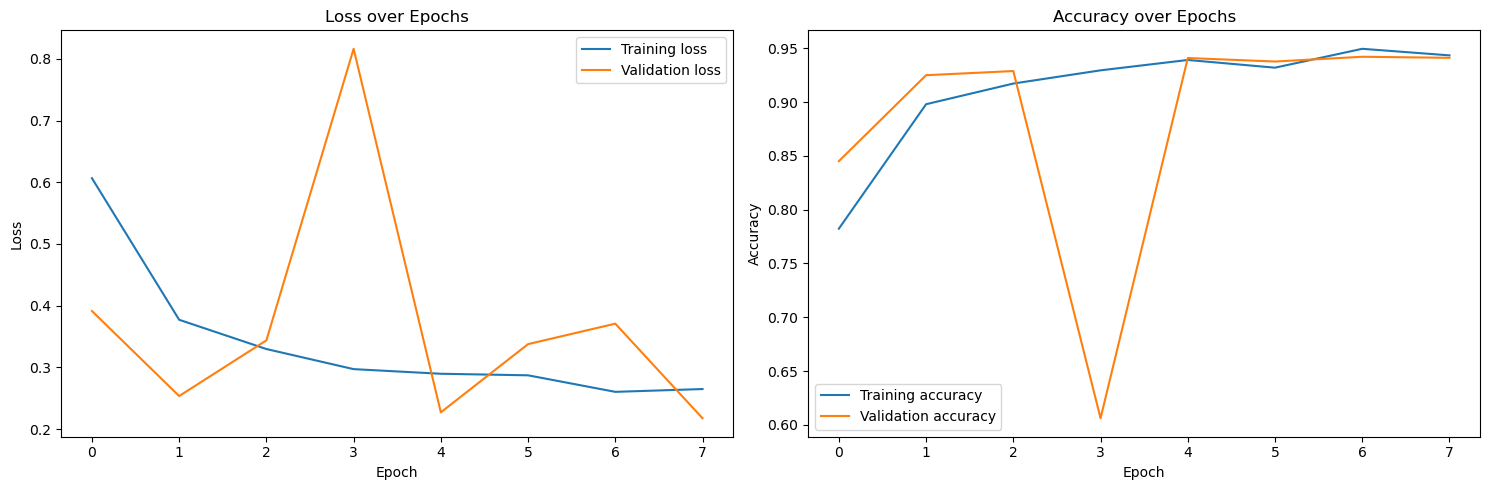

In [59]:
plot_training_history(history)

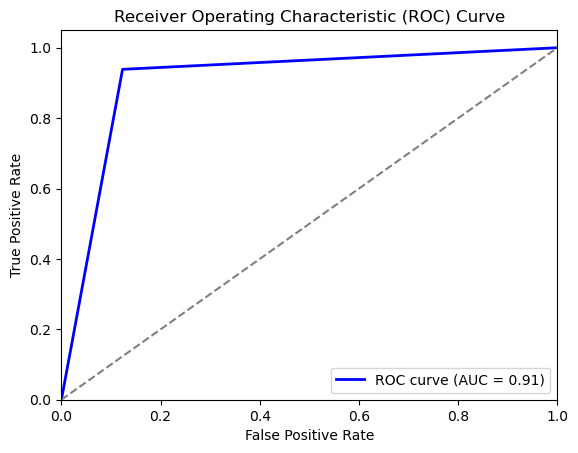

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_classes)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()